In [7]:
import pandas as pd
import numpy as np

import os
import json

from scipy import stats, special
from matplotlib import pyplot as plt

import failuremodes.generators
import failuremodes.links
import failuremodes.utils
import failuremodes.evaluation

%load_ext autoreload
%autoreload 2


# How to evalate model fit?

- Does the chain converge to a stable sampling distribution?

- What is the probability that a particular model is correct?

- How does the posterior compare with the distribution of the data?
    - In expectation
    - statistical distance

- How does the posterior compare with the data-generating process?
    - In expectation
    - statistical distance



In [107]:
scenarios = pd.read_csv(os.path.join('inputs','scenarios.csv'), index_col='name')

X = pd.read_csv(os.path.join('inputs','weather.csv'), index_col='time')

X = X[['Wind','DayPrecip','WindStorm','Precip']]


In [108]:
# summaries = {}

# gridsize = 20

# results = pd.DataFrame()

# cols = ['scenario','model','likelihood','bic','kl','upgrade']
# for key in X.keys():
#     cols.extend(['%s_true_mean'%(key), '%s_true_var'%(key)])
#     cols.extend(['%s_est_mean'%(key), '%s_est_var'%(key)])
# results = pd.DataFrame(columns=cols)
    
# bins = [np.linspace(X[key].min(), X[key].max(), 50) for key in X.keys()]

# x_probs = {}
# x_vals = {}
for keys in [['Wind',],['Wind','DayPrecip'],['Wind','Precip'],['Wind','DayPrecip','WindStorm'], ['Wind','Precip','WindStorm']]:
    print '+'.join(keys)
    if '+'.join(keys) in x_vals.keys():
        continue
    bins = [np.linspace(X[key].min(), X[key].max(), 100) for key in keys]
    p_x, x_bins = np.histogramdd(np.array(X[keys]), bins=bins)
    p_x = (p_x / float(len(X))).flatten()
    
    idx = p_x > 0
    
    x_probs['+'.join(keys)] = p_x[idx]
    
    x_array = np.meshgrid(*[_x[:-1] for _x in x_bins])
    df = pd.DataFrame(zip(*[p.flatten() for p in x_array]), columns=keys)
    x_vals['+'.join(keys)] = df[idx]
        
    print x_probs['+'.join(keys)].shape, x_vals['+'.join(keys)].shape

# results = {}
for s in scenarios.index:
    if s == 19:
        continue
    scenario = 'scenario%i'%(s)
    y = pd.read_csv('scenarios/%s/failures.csv'%(scenario), index_col='time')
    
    print scenario
    with open(os.path.join('scenarios', scenario, 'chains', 'metadata.txt'), 'r') as f:
        meta = f.read()
        
    meta = json.loads('[%s]'%(meta.replace('}{', '},{')))
    
    
    if scenario not in results.keys():

        results[scenario] = {}

        params = pd.read_csv(os.path.join('scenarios', scenario, 'parameters.csv'), index_col=0)
        params = params[params.keys()[pd.notnull(params.loc[0])]]

        for key in params.keys():
            if key.split('.')[0] in X.keys():
                new_label = '%s.%s'%(key.split('.')[1], key.split('.')[0])
                params = params.rename(columns={key: new_label})

        mean, cov = evaluation.param_distributions(params, true=True)
        results[scenario]['means'] = {'true': mean}
        results[scenario]['covs'] = {'true': cov}

        param_vals = evaluation.param_grid(mean, cov)
        results[scenario]['param_vals'] = {'true': param_vals}
        results[scenario]['pdfs'] = {'true': evaluation.param_probs(mean, cov, param_vals)}
        results[scenario]['poisson_probs'] = {'true': evaluation.param_probs(mean, cov, param_vals).flatten()}

    for entry in meta:
        
        model_name = entry.keys()[0]
        model = entry[model_name]
        param_list = model['variables']
        
        if model_name in results[scenario]['poisson_probs'].keys():
            continue
        
        if not os.path.exists(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name))):
            print 'skip reason 1', model_name
            pass
        else:
            params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
            params = params[param_list]

            params = evaluation.fix_naming_issue(params, X.keys())
            mean, cov = evaluation.param_distributions(params)
            if type(mean) == type(np.nan):
                print 'skipping', model_name
                continue
            
            results[scenario]['means'][model_name] = mean
            results[scenario]['covs'][model_name] = cov
            
            param_vals = evaluation.param_grid(mean, cov, gridsize=gridsize)
            results[scenario]['param_vals'][model_name] = param_vals
            results[scenario]['pdfs'][model_name] = evaluation.param_probs(mean, cov, param_vals).flatten()
            
            bin_area = evaluation.calc_grid_area(param_vals, gridsize)
            results[scenario]['pdfs'][model_name] *= bin_area
            
            if np.abs(results[scenario]['pdfs'][model_name].sum() - 1) > 0.01:
#                 print 'here'
                results[scenario]['pdfs'][model_name] = results[scenario]['pdfs'][model_name]/results[scenario]['pdfs'][model_name].sum()

            yvals = np.arange(0,300,1)
            results[scenario]['poisson_probs'][model_name] = pd.Series(0, index=yvals)

            for i, params in param_vals.iterrows():
                p_theta = results[scenario]['pdfs'][model_name][i]
                g_x = links.Link().failure_prob(params, x_vals[model_name])

                y = 0
                while results[scenario]['poisson_probs'][model_name].loc[:y].sum() < 1-1e-10:
                    p_y = (x_probs[model_name]*(np.exp(-1*10000*g_x) * (10000*g_x)**y/(special.factorial(y)))).sum()
                    results[scenario]['poisson_probs'][model_name].loc[y] += p_y * p_theta
                    y += 1

Wind
Wind+DayPrecip
Wind+Precip
Wind+DayPrecip+WindStorm
Wind+Precip+WindStorm
scenario1
scenario2
MARKOV CHAIN DID NOT CONVERGE
skipping Wind+DayPrecip
scenario3


/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in divide


KeyError: 300

In [ ]:
for s in scenarios.index[:1]:
    scenario = 'scenario%i'%(s)
    if s < 19:
        model_name = 'Wind'
    elif s == 19:
        continue
    else:
        model_name = 'Wind+DayPrecip'

    yvals = np.arange(0,300,1)
    results[scenario]['poisson_probs']['true'] = pd.Series(0, index=yvals)
    
    param_vals = evaluation.param_grid(results[scenario]['means']['true'], 
                                       results[scenario]['covs']['true'], 
                                       gridsize=gridsize)
    
    results[scenario]['pdfs']['true'] = evaluation.param_probs(mean, cov, param_vals).flatten()
    
    for i, params in param_vals.iterrows():
        p_theta = results[scenario]['pdfs']['true'][i]
        g_x = links.Link().failure_prob(params, x_vals[model_name])

        for y in yvals:
            p_y = (x_probs[model_name]*(np.exp(-1*10000*g_x) * (10000*g_x)**y/(special.factorial(y)))).sum()
            results[scenario]['poisson_probs']['true'].loc[y] += p_y * p_theta

In [ ]:
for s in results.keys():
    y = pd.DataFrame(columns=results[s]['poisson_probs'].keys(), index=range(300))
    for key in y.keys():
        y[key] = results[s]['poisson_probs'][key]
    y.to_csv(os.path.join('scenarios',s,'poisson_probs.csv'), index=True, index_label='y')
    

In [ ]:
pwd

In [ ]:
fig, ax = plt.subplots()
results['scenario5']['poisson_probs']['true'].plot(ax=ax)
ax.set_yscale('log')
plt.show()

results['scenario5']['poisson_probs']['true'].loc[:5]

In [ ]:
results['scenario5']['poisson_probs'].keys()



In [ ]:
for s in range(1,24):
    scenario = 'scenario%i'%(s)
    print '\n', scenario
    if scenario not in results.keys():
        continue
    
    for model in results[scenario]['means'].keys():
        
        idx = results[scenario]['poisson_probs']['true'] == np.inf
        results[scenario]['poisson_probs']['true'][idx] = 0
        
        if model not in results[scenario]['poisson_probs'].keys():
            print scenario, model, '\t', results[scenario]['means'][model].loc['threshold.Wind'], '\t', results[scenario]['covs'][model]['threshold.Wind'].loc['threshold.Wind'],'\t', np.nan, '\t', np.nan
            continue
            
        idx = results[scenario]['poisson_probs'][model] == np.inf
        results[scenario]['poisson_probs'][model][idx] = 0
        
        kl_div = []
        for y in results[scenario]['poisson_probs']['true'].index:
            if results[scenario]['poisson_probs']['true'].loc[y] < 1e-10:
                continue
            
            elif results[scenario]['poisson_probs'][model].loc[y] < 1e-10:
                continue
                
            kl_div.append(results[scenario]['poisson_probs']['true'].loc[y] 
                       * np.log(results[scenario]['poisson_probs']['true'].loc[y]
                                /results[scenario]['poisson_probs'][model].loc[y]))            
        print scenario, model, '\t', results[scenario]['means'][model].loc['threshold.Wind'], '\t', results[scenario]['covs'][model]['threshold.Wind'].loc['threshold.Wind'],'\t', len(kl_div), '\t', sum(kl_div)
        
        
        

In [ ]:
for i, scenario in scenarios.iterrows():
    params = generators.params(scenario, fleet_size=10000, seed=0)
    params = params[params.keys()[pd.notnull(params.loc[0])]]
    
    h, bins = np.histogram(params['Wind.threshold'].tolist(), bins=100)
    xvals = 0.5*(pd.Series(bins[1:])-pd.Series(bins[:-1]))
    fig, ax = plt.subplots()
    ax.hist(params['Wind.threshold'].tolist())
#     if scenario['Wind.threshold_distribution'] == 'constant':
#         pass
#     else:
#         ax.plot(xvals, stats.norm.pdf(*eval(scenario['Wind.threshold_hyperparams'])))
    plt.show()

# fig, ax = plt.subplots()
# ax.hist(params['Wind.threshold'].tolist())
# ax.set_title('%s, %s'%(np.average(params['Wind.threshold'].tolist()), np.std(params['Wind.threshold'].tolist())))
# plt.show()

In [ ]:
meta = '{"Wind": {"variables": ["slope.Wind", "threshold.Wind"], "sigma": [[2.442685569798745e-05, 0.00016710182908722987], [0.00016710182908722987, 0.06301778942747199]], "p0": [0.2983461343324667, 48.04093390540294], "time": "2019-09-21 04:15:05.498296"}}{"Wind+Precip": {"variables": ["slope.Precip", "slope.Wind", "threshold.Precip", "threshold.Wind"], "sigma": [[0.03822267195058332, 7.348828159947663e-05, 0.0, 0.00373740814561864], [7.348828159947663e-05, 2.6678701960190622e-05, 0.0, 0.0003721011034830428], [0.0, 0.0, 0.0, 0.0], [0.00373740814561864, 0.0003721011034830428, 0.0, 0.058792889702554745]], "p0": [1.4153227638927721, 0.31030270614393346, 0.0, 47.495204784227596], "time": "2019-09-21 04:58:30.871477"}}{"Wind+Precip+WindStorm": {"variables": ["slope.Precip", "slope.Wind", "slope.WindStorm", "threshold.Precip", "threshold.Wind", "threshold.WindStorm"], "sigma": [[0.0013486853657569385, -2.1165068095039567e-06, -3.408853957525224e-05, 0.0, 0.0009170375238749073, 8.571169158502491e-07], [-2.1165068095039567e-06, 2.8459644480976764e-05, -2.3315672886515614e-05, 0.0, 0.00017816535843032192, -1.9215839397282606e-07], [-3.408853957525224e-05, -2.3315672886515614e-05, 0.0007036261401256042, 0.0, 0.0020327151460704522, 4.339533288225968e-06], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0009170375238749073, 0.00017816535843032192, 0.0020327151460704522, 0.0, 0.05275169504286983, 2.5879614600133225e-05], [8.571169158502491e-07, -1.9215839397282606e-07, 4.339533288225968e-06, 0.0, 2.5879614600133225e-05, 5.224983901997714e-07]], "p0": [0.5914357583881481, 0.34499497186922473, -0.3529533188737937, 1.667581465998808e-11, 42.38543463129594, 0.002617737775153537], "time": "2019-09-21 05:41:19.296991"}}'

obj = json.loads('[%s]'%(meta.replace('}{', '},{')))
obj[0]

In [109]:
summaries = {}

results = pd.DataFrame()

cols = ['scenario','model','likelihood','bic','kl','upgrade']
for key in X.keys():
    cols.extend(['%s_true_mean'%(key), '%s_true_var'%(key)])
    cols.extend(['%s_est_mean'%(key), '%s_est_var'%(key)])
results = pd.DataFrame(columns=cols)
    
xvals = np.arange(1,150,10)
wind_hist = np.histogram(X['Wind'].tolist(), bins=xvals)
wind_hist = pd.Series(wind_hist[0], xvals[:-1])

results = {}
for s in scenarios.index:
    scenario = 'scenario%i'%(s)
    y = pd.read_csv('scenarios/%s/failures.csv'%(scenario), index_col='time')

    with open(os.path.join('scenarios', scenario, 'chains', 'metadata.txt'), 'r') as f:
        meta = f.read()
        
    meta = json.loads('[%s]'%(meta.replace('}{', '},{')))
    
    results[scenario] = {}
    
    params = pd.read_csv(os.path.join('scenarios', scenario, 'parameters.csv', index=0))
    params = params[params.keys()[pd.notnull(params.loc[0])]]
    
    mean, cov = evaluation.param_distributions(params, true=True)
    results[scenario]['means'] = {'true': mean}
    results[scenario]['covs'] = {'true': cov}
    
    for entry in meta:
        
        model_name = entry.keys()[0]
        model = entry[model_name]
        param_list = model['variables']
        
        if not os.path.exists(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name))):
            pass
        else:
            params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
            params = mcmc_params[param_list]
            
            mean, cov = evaluation.param_distributions(params)
            results[scenario]['means'] = {model_name: mean}
            results[scenario]['covs'] = {model_name: cov}
        
#     grid_lims = {}
#     for model in results[scenario]['means'].keys():
#         for param in results[scenario]['means'][model].index:
#             if param not in grid_lims.
#             mean = results[scenario]['means'][model].loc[param]
#             std = np.sqrt(results[scenario]['covs'][model][param].loc[param])
#             mins.append(mean - 5*std)
#             maxs.append(mean + 5*std)
#         grid_lims
        
    grid_lims = [results[scenario]['means']-5*np.sqrt(np.diag(results[scenario]['covs']))]
            
            
            logL = pd.Series()
            for i in np.arange(5000,len(mcmc_params), 100):
                logL.loc[i] = utils.calc_likelihood(mcmc_params.loc[i], X, y['count'], links.Link(), 10000)
            
            result['likelihood'] = np.average(logL)
            result['bic'] = np.log(len(y))*len(model_name.split('+')) - 2*np.average(logL)
            
            for key in mcmc_params.keys():
                result['%s_est_mean'%(key)] = mcmc_params[key].mean()
                result['%s_est_std'%(key)] = mcmc_params[key].std()
            
            for key in true_params.keys():
                result['%s_true_mean'%(key)] = true_params[key].mean()
                result['%s_true_std'%(key)] = true_params[key].std()
            
            
            bins = np.array(zip(*[p.flatten() for p in grid]))
            probs[s][model_name] = {'true': stats.multivariate_normal.pdf(bins, mean=, cov=),
                                   'est': stats.multivariate_normal.pdf(bins, mean=true_mean, cov=),
                                   'bins': bins}
            
    summaries[scenario] = summary
        

IndentationError: unexpected indent (<ipython-input-109-65c2f07fefb4>, line 63)

# Choose the model that's most likely

The problem with this approach is that my system is over parameterized. The data generating process is just a constant. Models with more parameters aren't less likely, the likelihood is about the same (obviously), but they don't provide meaningful insights. 

Looking at plots in 5.2, over parameterized models have unstable sampling distributions in the markov chain. Would it make sense to choose a model based on sampling stability, rather than likelihood?

**Scott tip:** Learn about Fisher Information
https://en.wikipedia.org/wiki/Fisher_information

In [280]:
results = pd.DataFrame(columns=['scenario','model','alpha_mean','alpha_var','beta_mean','beta_var','bic','kl','upgrade'])


model_selection = []

for s in scenarios.index:
    scenario = 'scenario%i'%(s)
    best_bic = summaries[scenario]['bic'].idxmin()
    
    df = pd.DataFrame(index=summaries[scenario]['bic'])
    
    df['alpha'] = scenarios['Wind.threshold'].loc[s]
    df['\hat{alpha}'] = _params['mean'].loc['threshold.Wind']
    
    df['beta'] = scenarios['Wind.slope'].loc[s]
    df['\hat{beta}'] = _params['mean'].loc['slope.Wind']
    
    df['bic'] = summaries[scenario]['bic']-best_bic
    
    _params = summaries[scenario]['params'][summaries[scenario]['bic'].idxmin()]
    _params = _params[pd.notnull(_params.loc[0])]
    
    p_mean = _params.mean()
    p_cov = _params.cov()
    
#     grids = [np.linspace(p_mean[i]-5*np.sqrt(p_cov[i].loc[i]), 
#                          p_mean[i]-5*np.sqrt(p_cov[i].loc[i]), 
#                          100) 
#              for i in _params.keys()]
    
#     p_vals = np.meshgrid(*grids)
#     pdf = stats.multivariate_normal.pdf(p_vals, mean=p_mean, cov=p_cov)
    
#     probs = pd.DataFrame(columns=['true','estimate'], index=range(1e5))
#     for y in probs.index:
        
    
    print (s, '\t', 
           np.round(_params['mean'].loc['threshold.Wind'],0), '\t',
           np.round(np.sqrt(_params['var'].loc['threshold.Wind'],0)), '\t',
           np.round(_params['mean'].loc['slope.Wind'],0), '\t',
           np.round(np.sqrt(_params['mean'].loc['slope.Wind'],0)), '\t',
           
          )
    
    _params = summaries[scenario]['mcmc'].loc[np.arange(5000,len(summaries[scenario]['mcmc']),10)]
    print _params.mean().loc['threshold.Wind'], np.sqrt(_params.var().loc['threshold.Wind'])


SyntaxError: invalid syntax (<ipython-input-280-a2d1e0a68406>, line 8)

ValueError: zero-size array to reduction operation minimum which has no identity

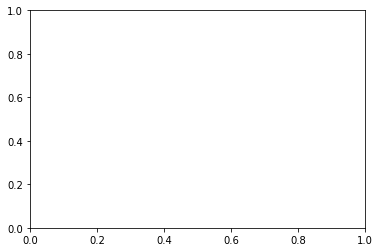

In [82]:
estimated = []
true = []
for s, row in scenarios.iterrows():
    scenario = 'scenario%s'%(s)
    if scenario in summaries.keys():
        estimated.append(summaries[scenario]['mcmc'].loc[np.arange(5000,len(summaries[scenario]['mcmc']),10)])
        true.append(generators.params(row, fleet_size=10000, seed=0))

fig, ax = plt.subplots()
ax.violinplot([t['Wind.threshold'].tolist() for t in true], np.arange(len(true)), widths=0.3)
ax.violinplot([e['threshold.Wind'].tolist() for e in estimated], np.arange(len(estimated))+0.3, widths=0.3)
ax.hist([], histtype='stepfilled', color='amber', alpha=0.5, label=r'Estimated')
ax.hist([], histtype='stepfilled', color='windows blue', alpha=0.5, label=r'True')
plt.legend()
plt.show()

# n = range(0,100)
# x = np.arange(0,150)
# p_x = stats.norm.pdf(x, X['Wind'].mean(), np.std(X['Wind']))

# prob_true = pd.DataFrame(0, columns=range(len(true)), index=x)
# prob_est = pd.DataFrame(0, columns=range(len(true)), index=x)
# fig, ax = plt.subplots()
# for i, (t, e) in enumerate(zip(true, estimated)):
#     for j, _t in t.iterrows():
#         prob_true[i] += 1./(1+np.exp(-1*_t['Wind.slope']*(x-_t['Wind.threshold'])))
    
#     for j, _e in e.iterrows():
#         prob_est[i] += 1./(1+np.exp(-1*_e['slope.Wind']*(x-_e['threshold.Wind'])))



/Users/laureldunn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


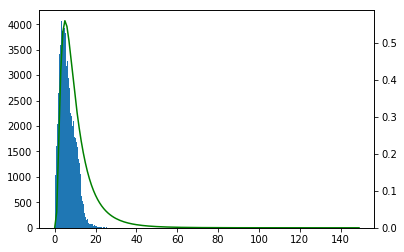

In [238]:
n = range(0,100)
x = np.arange(0,150)
p_x = stats.norm.pdf(np.log(x), np.log(X['Wind']).mean(), np.std(np.log(X['Wind'])))

fig, ax = plt.subplots()
ax.hist(X['Wind'].tolist(), bins=100)
ax2 = plt.twinx()
ax2.plot(x, p_x, color='g')
ax2.set_ylim(0,ax2.get_ylim()[1])
plt.show()

0


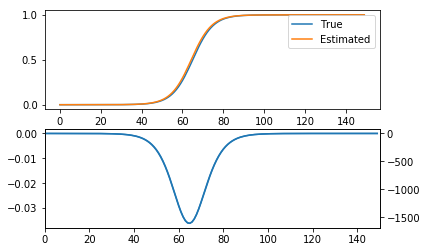

1


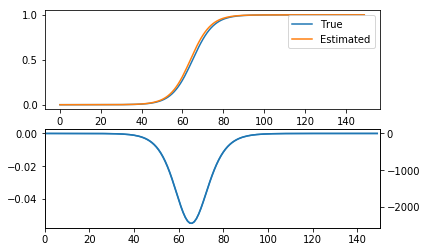

2


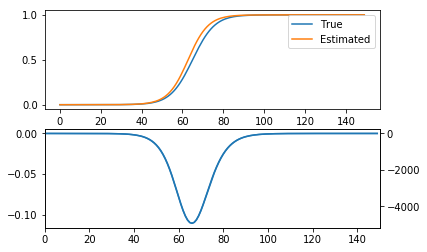

3


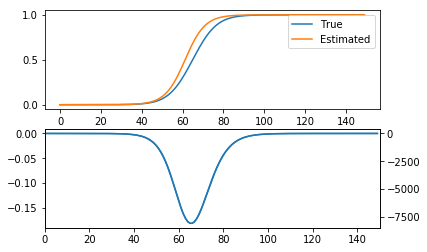

4


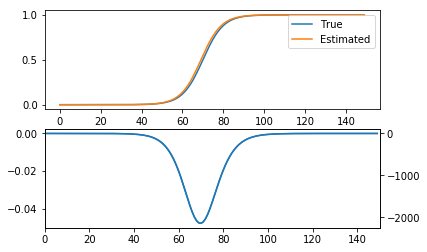

5


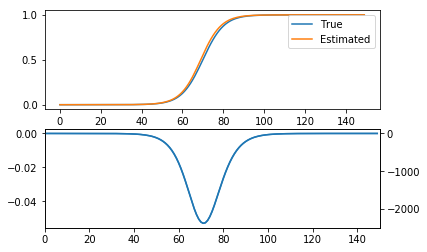

6


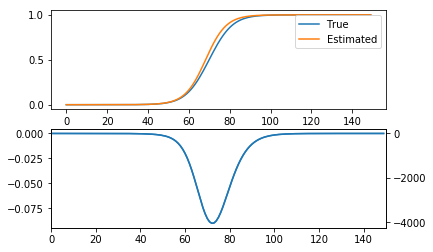

7


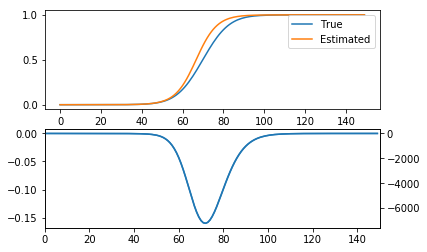

8


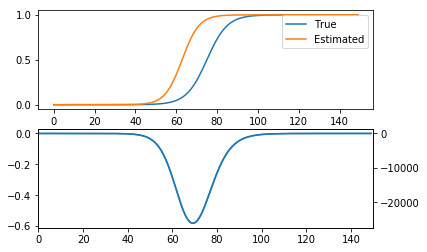

9


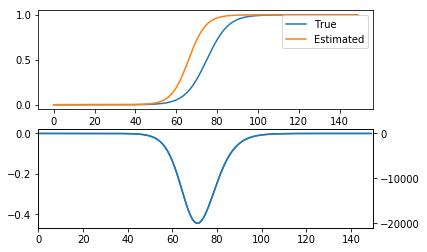

10


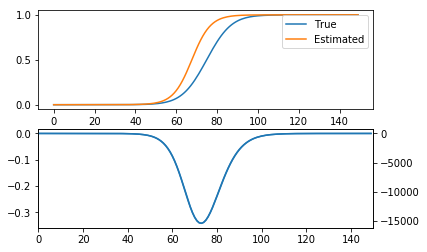

11


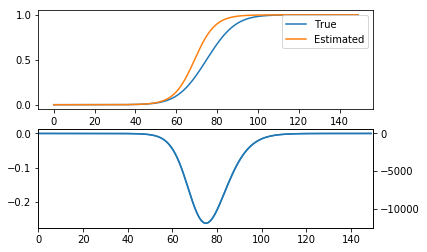

In [254]:
metrics = pd.DataFrame(columns=['threshold','cov','kl divergence','ks test','shortfall','upgrades'], index=prob_true.keys())
for key in prob_true.keys():
    print key
    prob_true[key] = prob_true[key]/prob_true[key].max()
    prob_est[key] = prob_est[key]/prob_est[key].max()
    
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(x, prob_true[key], label='True')
    ax[0].plot(x, prob_est[key], label='Estimated')
    ax[0].legend()
    
    ax[1].plot(x, prob_true[key]-prob_est[key], label='difference')
    ax[1].set_xlim(0,150)

    ax2 = ax[1].twinx()
    
    p_x = stats.lognorm.pdf(x, X['Wind'].mean(), np.std(X['Wind']))
    ax2.plot(x, 1e5*p_x.cumsum()*(prob_true[key]-prob_est[key]), label='risk')
    ax2.set_xlim(0,150)
    plt.show()
    
#     metrics['mean'] = 
    metrics['kl divergence'].loc[key] = sum(prob_true[key]*(np.log(prob_true[key]) - np.log(prob_est[key])))
    metrics['ks test'].loc[key] = 8760*max(np.abs(prob_true[key]-prob_est[key]))
    metrics['shortfall'].loc[key] = 8760*sum(p_x*(prob_true[key] - prob_est[key]))


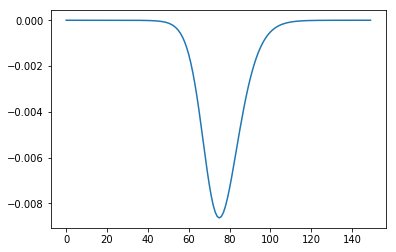

In [251]:
_p_x = (1-p_x.cumsum())*(prob_true[key] - prob_est[key])
fig, ax = plt.subplots()
ax.plot(x, _p_x)

In [247]:
metrics['shortfall'] *= 8760
metrics

,kl divergence,ks test,shortfall,upgrades
0,-0.694762,0,-0.0110877,NaN
1,-1.04205,0,-0.0110906,NaN
2,-2.02795,0,-0.0103118,NaN
3,-3.26011,0,-0.00816562,NaN
4,-0.902925,0,-0.00277308,NaN
5,-1.00196,0,-0.00371346,NaN
6,-1.63626,0,-0.00579529,NaN
7,-2.96694,0,-0.0103051,NaN
8,-6.85798,3.55354e-07,0.00217758,NaN
9,-6.05756,3.95695e-06,0.00676431,NaN


In [106]:
model_name = bic.idxmin()
mcmc_params = pd.read_csv(os.path.join('scenarios', scenario, 'chains', '%s.csv'%(model_name)), index_col=0)
mcmc_params = mcmc_params.loc[5000:]

In [107]:
fleet_size = 10000
xvals = np.arange(0,150)

H = np.histogramdd(np.array(mcmc_params), bins=100)
bins = np.meshgrid(*[a[:-1] for a in H[1]])

print sum(H[0].flatten()), max(H[0].flatten())

df = pd.DataFrame(index=H[0].flatten().astype(float)/H[0].sum(), columns=mcmc_params.keys())
for i, col in enumerate(mcmc_params):
    df[col] = bins[i].flatten()
    
idx = df.index > 0
df = df[idx]
print len(df)

failures = pd.Series(0, index=X.index)
for wt, params in df.iterrows():
    exp = pd.Series(0, index=X.index)
    for dim in X.keys():
        if 'slope.%s'%(dim) in params.keys():
            exp += params['slope.%s'%(dim)]*(X[dim]-params['threshold.%s'%(dim)])
    failures += wt * fleet_size / (1. + np.exp(-1*exp))



45001.0 446.0
1212


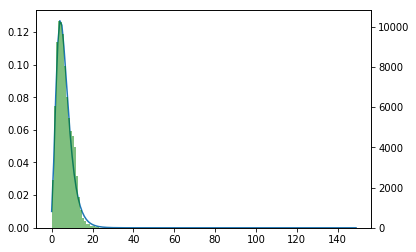

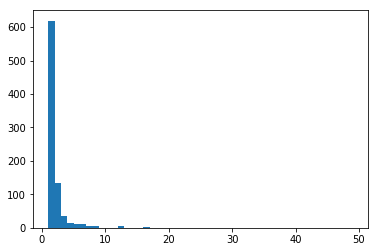

In [110]:
p_x = stats.lognorm.pdf(xvals, *stats.lognorm.fit(X['Wind']))

fig, ax = plt.subplots()
ax.plot(xvals, p_x)
ax.set_ylim(0, ax.get_ylim()[1])
ax2 = ax.twinx()
ax2.hist(X['Wind'], bins=xvals, color='g', alpha=0.5)
# ax.set_xscale('log')
plt.show()

fig, ax = plt.subplots()
ax.hist(failures.tolist(), bins=range(1,50))
plt.show()

# fig, ax = plt.subplots()
# ax.plot(xvals[:-1], p_x[:-1]*np.histogram(failures, xvals)[0])
# ax.set_yscale('log')
# plt.show()

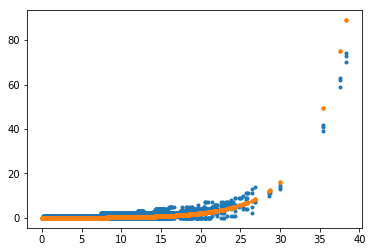

In [109]:
fig, ax = plt.subplots()
ax.plot(X['Wind'].tolist(), y['count'].tolist(), ls=' ', marker='.')
ax.plot(X['Wind'].tolist(), failures.tolist(), ls=' ', marker='.')
plt.show()

In [85]:
# Contour plot showing P(Y=y|x)
# Histogram showing upgrade policy
# Plot contour of logistic functions - actual and estimated

,count,rate
time,,
0,0.0,0.070252
1,0.0,0.048818
2,0.0,0.044084
3,0.0,0.046623
4,0.0,0.048043


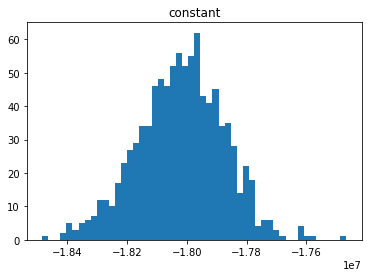

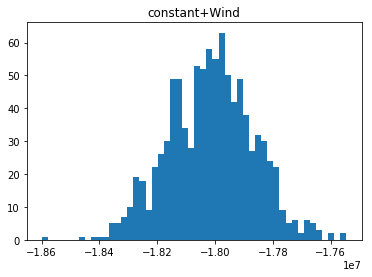

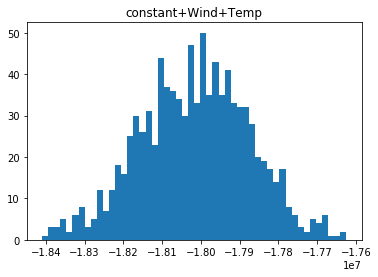

In [15]:
for key in likelihoods.keys():
    fig, ax = plt.subplots()
    ax.hist(likelihoods[key], bins=50)
    ax.set_title(key)
    plt.show()

In [7]:
bic = pd.Series(index=likelihoods.index)

n = len(y)
for model_name in bic.index:
    k = 2*len(model_name.split('+'))
    bic.loc[model_name] = np.log(n)*y - 2*likelihoods.loc[model_name]

print bic.sort_values()


pd.DataFrame(likelihoods).mean().sort_values()


ValueError: Incompatible indexer with DataFrame

In [9]:
likelihoods

constant              5000     -1.825927e+07
5100     -1.787837e+07
...
constant+Wind         5000     -1.800790e+07
5100     -1.788693e+07
...
constant+Wind+Temp    5000     -1.814516e+07
5100     -1.791683e+07
...
dtype: object

-1578.1620113271558

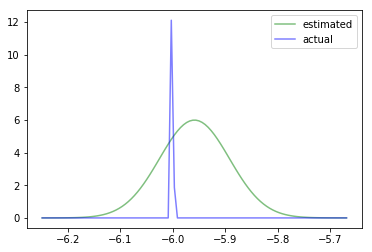

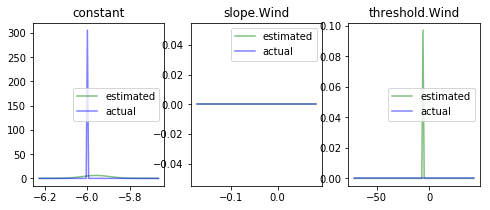

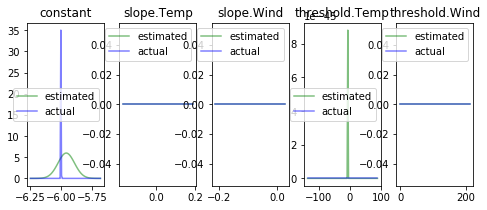

In [111]:
y = pd.read_csv('scenarios/scenario0/failures.csv', index_col='time')

for entry in meta:
    model_name = entry.keys()[0]
    model = entry[model_name]
    
    param_list = model['variables']
    mcmc_params = pd.read_csv(os.path.join('scenarios', 'scenario0', 'chains', '%s.csv'%(model_name)), index_col=0)
        
    if len(param_list) == 1:
        p = param_list[0]

        fig, ax = plt.subplots()
        bins = np.linspace(mcmc_params[p].loc[1000:].min(), mcmc_params[p].loc[1000:].max(), 100)
        
        estimated = stats.norm.fit(mcmc_params[p].loc[1000:].tolist())
        actual = stats.norm.fit(params[p].tolist())

        ax.plot(bins, stats.norm.pdf(bins, *estimated), color='g', alpha=0.5, label='estimated')
        ax.plot(bins, stats.norm.pdf(bins, *actual), color='b', alpha=0.5, label='actual')
        
        ax.legend()

    else:
        fig, ax = plt.subplots(figsize=(8,3), ncols=len(param_list))
    
        for i, p in enumerate(param_list):
            bins = np.linspace(mcmc_params[p].loc[1000:].min(), mcmc_params[p].loc[1000:].max(), 100)

            ax[i].plot(bins, stats.norm.pdf(bins, *estimated), color='g', alpha=0.5, label='estimated')
            ax[i].plot(bins, stats.norm.pdf(bins, *actual), color='b', alpha=0.5, label='actual')
            ax[i].set_title(p)
            
            ax[i].legend()
    plt.show()

In [102]:
np.log(failures.mean())

count   -3.840446
rate    -3.789622
dtype: float64

KeyboardInterrupt: 

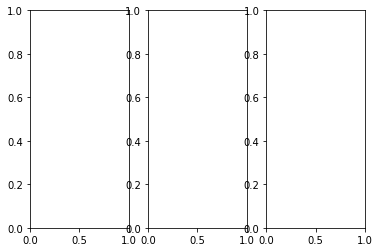

In [27]:
fig, ax = plt.subplots(ncols=len(X.keys()))

for i, key in enumerate(X.keys()):
    x_vals = np.linspace(X[key].min(), X[key].max(), 100)
    x_in = X.mean()*pd.DataFrame(1, columns=X.keys(), index=range(len(x_vals)))
    x_in[key] = x_vals
            
    rates = pd.DataFrame(index=_params.index, columns=x_vals)
    for j in params.index:
        rates.loc[j] = links.Link().failure_rate(_params.loc[j], x_in)
        
    for key in rates.keys():
        ax[i].plot(key*np.ones(len(rates),), rates[key].tolist(), ls=' ', marker='.', color='g', alpha=0.1)
plt.show()

In [26]:
x_in = X.mean()*pd.DataFrame(1, columns=X.keys(), index=range(100))


In [23]:
x_in.head()

,Wind,Precip,Temp
0,6.286487,0.001303,58.068202
1,6.286487,0.001303,58.068202
2,6.286487,0.001303,58.068202
3,6.286487,0.001303,58.068202
4,6.286487,0.001303,58.068202
